## N번 촬영한 마커 이미지를 평균

In [28]:
import os
import json
import cv2
import numpy as np
from collections import defaultdict
from scipy.spatial.transform import Rotation as R

# 디렉토리 설정
base_dirs = [
    "./ArUco_cap_250514",
    "./ArUco_cap2_250514",
    "./ArUco_cap3_250514"
]
output_dir = "./Correct_ArUco"
os.makedirs(output_dir, exist_ok=True)

# 파일 이름에서 뷰와 카메라 추출
def parse_filename(filename):
    parts = filename.split('_')
    view = parts[0]
    cam = parts[2]
    return view, cam

# 데이터 구조: data[view][cam][marker_id] = list of marker dicts
data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# 파일 수집 및 데이터 적재
for base_dir in base_dirs:
    for fname in os.listdir(base_dir):
        if not fname.endswith('.json'):
            continue
        view, cam = parse_filename(fname)
        with open(os.path.join(base_dir, fname), 'r') as f:
            content = json.load(f)
            for marker_id, marker_data in content.items():
                data[view][cam][marker_id].append(marker_data)

# 회전 평균
def average_quaternion(quaternions):
    M = np.zeros((4, 4))
    for q in quaternions:
        q = q.reshape(4, 1)
        M += q @ q.T
    eigvals, eigvecs = np.linalg.eigh(M)
    avg_quat = eigvecs[:, np.argmax(eigvals)]
    return avg_quat / np.linalg.norm(avg_quat)

# 위치 평균
def average_position(positions):
    return np.mean(positions, axis=0)

# 마커 정리 및 저장
for view in data: # ['top', 'right', 'front', 'left']
    for cam in data[view]: # ['leftcam', 'rightcam']
        corrected = {}
        for marker_ids, entries in data[view][cam].items():
            if len(entries) < 2:
                continue  # 최소 두 개 이상 있어야 평균
            positions = [np.array([m['position_m']['x'], m['position_m']['y'], m['position_m']['z']]) for m in entries]
            quaternions = [np.array([m['rotation_quat']['x'], m['rotation_quat']['y'],
                                    m['rotation_quat']['z'], m['rotation_quat']['w']]) for m in entries]

            avg_pos = average_position(positions)
            avg_quat = average_quaternion(quaternions)

            corrected[marker_ids] = {
                "position_m": {"x": float(avg_pos[0]), "y": float(avg_pos[1]), "z": float(avg_pos[2])},
                "rotation_quat": {"x": float(avg_quat[0]), "y": float(avg_quat[1]),
                                "z": float(avg_quat[2]), "w": float(avg_quat[3])},
                "corners_pixel": entries[0]["corners_pixel"]
            }

        output_path = os.path.join(output_dir, f"{view}_{cam}_corrected.json")
        with open(output_path, 'w') as f:
            json.dump(corrected, f, indent=4)

print("보정된 결과가 다음 디렉토리에 저장되었습니다:", output_dir)

보정된 결과가 다음 디렉토리에 저장되었습니다: ./Correct_ArUco


## 평균값에서 회전은 동일하다고 가정하여, 거리별 가중치 노이즈 제거하여 회전 벡터 구하기

In [36]:
import os
import json
import numpy as np
from scipy.spatial.transform import Rotation as R
from collections import defaultdict

# 디렉토리 설정
corrected_dirs = "./Correct_ArUco"
output_dir = "./Rot_Tvec_corrected_ArUco"
os.makedirs(output_dir, exist_ok=True)

# 파일 이름에서 뷰와 카메라 추출
def parse_filename(filename):
    parts = filename.split('_')
    view = parts[0]
    cam = parts[1]
    return view, cam

# 데이터 구조: data[view][cam][marker_id] = list of marker dicts
data = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# 파일 수집 및 데이터 적재
for fname in os.listdir(corrected_dirs):
    if not fname.endswith('.json'):
        continue
    view, cam = parse_filename(fname)
    with open(os.path.join(corrected_dirs, fname), 'r') as f:
        content = json.load(f)
        for marker_id, marker_data in content.items():
            data[view][cam][marker_id].append(marker_data)

ANGLE_THRESH_DEG = 1.5  # 회전 이상치 판정 임계각

for view, cams in data.items():
    for cam, markers in cams.items():
        # (1) 포즈 수집
        tvecs, quats, ids = [], [], []
        for marker_id, entries in markers.items():
            m = entries[0]
            tvecs.append([m['position_m'][k] for k in ('x', 'y', 'z')])
            quats.append([m['rotation_quat'][k] for k in ('x', 'y', 'z', 'w')])
            ids.append(marker_id)

        tvecs = np.array(tvecs)
        quats = np.array(quats)
        N = len(ids)

        if N < 2:
            print(f"{view}/{cam}: 마커 {N}개라 스킵")
            continue

        # (2) 거리 가중치
        dists = np.linalg.norm(tvecs, axis=1)
        weights = 1.0 / (dists + 1e-6)
        weights /= weights.sum()

        # (3) 회전 이상치 제거
        def total_angdist(qi, all_q):
            dots = np.abs(np.dot(all_q, qi))
            return np.sum(2 * np.arccos(np.clip(dots, -1, 1)))

        scores = [total_angdist(quats[i], quats) for i in range(N)]
        q_med = quats[np.argmin(scores)]
        dots = np.abs(np.dot(quats, q_med))
        thetas = 2 * np.arccos(np.clip(dots, -1, 1))
        mask = thetas < np.deg2rad(ANGLE_THRESH_DEG)

        excluded = [ids[i] for i in range(N) if not mask[i]]
        if excluded:
            print(f"[{view}/{cam}] 제외된 마커 (θ≥{ANGLE_THRESH_DEG}°): {excluded}")
        if mask.sum() < 2:
            print(f"{view}/{cam}: inlier <2 → 스킵")
            continue

        # (4) 회전 평균 (inlier만 사용)
        quats_f = quats[mask]
        w_f = weights[mask]
        w_f /= w_f.sum()

        M = sum(w * np.outer(q, q) for q, w in zip(quats_f, w_f))
        eigvals, eigvecs = np.linalg.eigh(M)
        q_mean = eigvecs[:, np.argmax(eigvals)]
        q_mean /= np.linalg.norm(q_mean)

        # (5) 출력 JSON 생성 & 저장 (inlier만 저장, tvec은 원래 값 유지)
        inlier_ids = [ids[i] for i in range(N) if mask[i]]
        corrected_output = {}
        for mid in inlier_ids:
            corrected_output[mid] = {
                "position_m": markers[mid][0]["position_m"],  # 원래 위치 그대로
                "rotation_quat": {
                    "x": float(q_mean[0]),
                    "y": float(q_mean[1]),
                    "z": float(q_mean[2]),
                    "w": float(q_mean[3])
                },
                "corners_pixel": markers[mid][0]["corners_pixel"]
            }

        # (6) 파일 저장
        out_fname = f"{view}_{cam}_RotTvec_corrected.json"
        with open(os.path.join(output_dir, out_fname), "w") as fout:
            json.dump(corrected_output, fout, indent=4)

        print(f"[{view}/{cam}] 저장: {out_fname}")


[left/leftcam] 제외된 마커 (θ≥1.5°): ['4']
[left/leftcam] 저장: left_leftcam_RotTvec_corrected.json
[left/rightcam] 제외된 마커 (θ≥1.5°): ['4']
[left/rightcam] 저장: left_rightcam_RotTvec_corrected.json
[top/leftcam] 제외된 마커 (θ≥1.5°): ['8', '5']
[top/leftcam] 저장: top_leftcam_RotTvec_corrected.json
[top/rightcam] 제외된 마커 (θ≥1.5°): ['8']
[top/rightcam] 저장: top_rightcam_RotTvec_corrected.json
[right/leftcam] 제외된 마커 (θ≥1.5°): ['8']
[right/leftcam] 저장: right_leftcam_RotTvec_corrected.json
[right/rightcam] 제외된 마커 (θ≥1.5°): ['8']
[right/rightcam] 저장: right_rightcam_RotTvec_corrected.json
[front/leftcam] 제외된 마커 (θ≥1.5°): ['1', '6']
[front/leftcam] 저장: front_leftcam_RotTvec_corrected.json
[front/rightcam] 제외된 마커 (θ≥1.5°): ['2', '1', '6']
[front/rightcam] 저장: front_rightcam_RotTvec_corrected.json


## 구한 회전값을 토대로 기존 값 보정

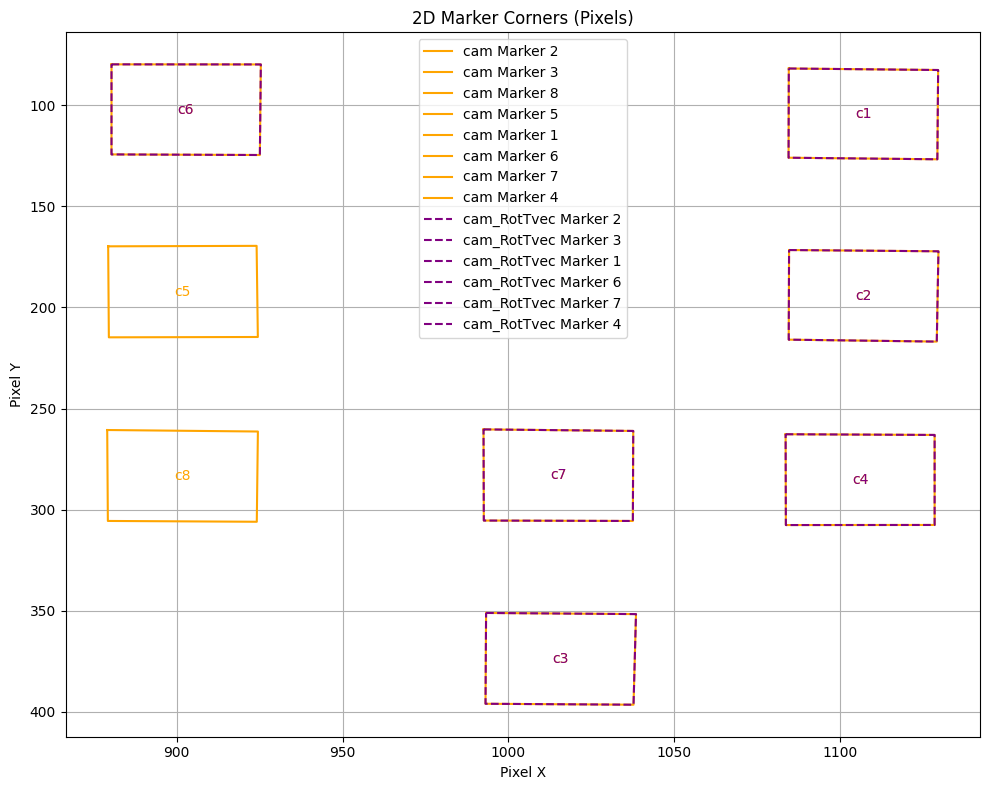

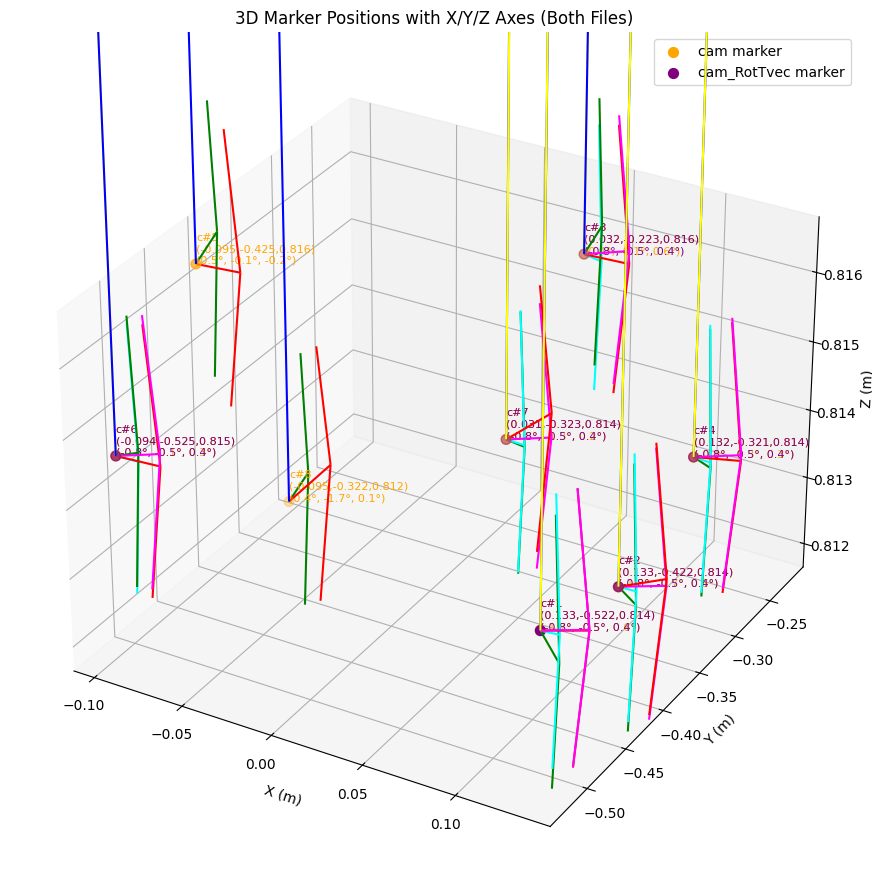

In [37]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

# 파일 경로
json_path1 = "/home/zed_box/Documents/ZED_Cap_make_dataset/Correct_ArUco/top_leftcam_corrected.json"
json_path2 = "/home/zed_box/Documents/ZED_Cap_make_dataset/Rot_Tvec_corrected_ArUco/top_leftcam_RotTvec_corrected.json"

with open(json_path1, 'r') as f:
    marker_data1 = json.load(f)
with open(json_path2, 'r') as f:
    marker_data2 = json.load(f)

# 파일별 시각화 옵션
file_infos = [
    {"data": marker_data1, "label": "cam", "color": "orange", "linestyle": "-", "axis_colors": {'x': 'red', 'y': 'green', 'z': 'blue'}},
    {"data": marker_data2, "label": "cam_RotTvec", "color": "purple", "linestyle": "--", "axis_colors": {'x': 'magenta', 'y': 'cyan', 'z': 'yellow'}}
]

# 1) 2D 시각화 (Pixel 기준)
fig, ax = plt.subplots(figsize=(10, 8))
for info in file_infos:
    for marker_id, data in info["data"].items():
        corners = np.array(data["corners_pixel"])
        poly = np.vstack([corners, corners[0]])
        ax.plot(poly[:, 0], poly[:, 1], label=f'{info["label"]} Marker {marker_id}', color=info["color"], linestyle=info["linestyle"])
        center = corners.mean(axis=0)
        ax.text(center[0], center[1], f'{info["label"][0]}{marker_id}', fontsize=10, ha='center', va='center', color=info["color"])

ax.set_xlabel('Pixel X')
ax.set_ylabel('Pixel Y')
ax.set_title('2D Marker Corners (Pixels)')
ax.invert_yaxis()
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) 3D 위치 + 회전 축 시각화
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for info in file_infos:
    positions = []
    labels = []
    rotated_axes = {'x': [], 'y': [], 'z': []}
    unit_axes = {'x': np.array([1, 0, 0]), 'y': np.array([0, 1, 0]), 'z': np.array([0, 0, 1])}

    for marker_id, data in info["data"].items():
        pos = data["position_m"]
        quat = data["rotation_quat"]
        r = R.from_quat([quat["x"], quat["y"], quat["z"], quat["w"]])
        positions.append([pos["x"], pos["y"], pos["z"]])
        labels.append(marker_id)
        for axis, unit_vec in unit_axes.items():
            rotated = r.apply(unit_vec)
            rotated_axes[axis].append(rotated)
    positions = np.array(positions)
    for axis in rotated_axes:
        rotated_axes[axis] = np.array(rotated_axes[axis])

    # 산점도 및 회전축
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], c=info["color"], s=50, label=f'{info["label"]} marker')
    for i, label in enumerate(labels):
        for axis in ['x', 'y', 'z']:
            ax.quiver(
                positions[i, 0], positions[i, 1], positions[i, 2],
                rotated_axes[axis][i, 0], rotated_axes[axis][i, 1], rotated_axes[axis][i, 2],
                length=0.025, color=info["axis_colors"][axis])
        # 위치 및 회전 텍스트 추가
        x, y, z = positions[i]
        quat = info["data"][label]["rotation_quat"]
        r = R.from_quat([quat["x"], quat["y"], quat["z"], quat["w"]])
        euler_deg = r.as_euler('xyz', degrees=True)  # XYZ 순서, deg로 변환
        ex, ey, ez = euler_deg

        ax.text(
            x, y, z,
            f'{info["label"][0]}#{label}\n({x:.3f},{y:.3f},{z:.3f})\n({ex:.1f}°, {ey:.1f}°, {ez:.1f}°)',
            color=info["color"],
            fontsize=8
        )


ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Marker Positions with X/Y/Z Axes (Both Files)')
ax.legend()
plt.tight_layout()
plt.show()
